In [21]:
import pandas as pd


import numpy as np
import os

import sklearn.metrics as metrics

from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, recall_score, \
    accuracy_score, precision_score, r2_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import sklearn
print(sklearn.__version__)

0.23.1


In [28]:
USE_3PLEX=True
USE_1PLEX_POS=True
USE_2PLEX_POS=True
USE_3PLEX_POS=True


In [23]:
df_sample = pd.read_csv("data/sample.csv")

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#df_labels_cols = list(df_train_labels)





In [4]:
df_train

,Sequence,Active
0,DKWL,0
1,FCHN,0
2,KDQP,0
3,FNWI,0
4,NKRM,0
...,...,...
111995,GSME,0
111996,DLPT,0
111997,SGHC,0
111998,KIGT,0


In [5]:
df_sample

,1
0,0
1,0
2,1
3,0
4,0
...,...
47994,0
47995,1
47996,0
47997,1


In [6]:
df_test

,Sequence
0,HWFK
1,MWPW
2,ALDV
3,NTLG
4,LHYY
...,...
47995,NRWM
47996,MMMK
47997,AFNM
47998,CRYI


In [90]:
def gen_feats_dict(df_train):
    #filtered = df_train[df_train['Active']==1]
    #fv = filtered['Sequence'].values
    fv = df_train['Sequence'].values
    

    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    feats1 = list(set(fv_1plex_list))
    print(len(feats1))
        
        
    fv_2plex_list = []
    for i in range(len(fv)):
        for j in range(0,3):
            fv_2plex_list.append(fv[i][j:j+2])
    feats2 = list(set(fv_2plex_list))
    print(len(feats2))

    feats_dict = {'1plex':feats1,
                '2plex':feats2}

    if USE_3PLEX:
        fv_3plex_list = []
        for i in range(len(fv)):
            for j in range(0,2):
                fv_3plex_list.append(fv[i][j:j+3])
        feats3 = list(set(fv_3plex_list))
        print(len(feats3))

        feats_dict['3plex']=feats3
    
    if USE_1PLEX_POS:
        feats_dict['1plex_pos0']=feats1
        feats_dict['1plex_pos1']=feats1
        feats_dict['1plex_pos2']=feats1
        feats_dict['1plex_pos3']=feats1
        
    if USE_2PLEX_POS:
        feats_dict['2plex_pos0']=feats2
        feats_dict['2plex_pos1']=feats2
        feats_dict['2plex_pos2']=feats2

    if USE_3PLEX_POS:
        feats_dict['3plex_pos0']=feats3
        feats_dict['3plex_pos1']=feats3
        
    return(feats_dict)






    


In [25]:
def gen_occ(df,feats_dict):
    
    fv = df['Sequence'].values
    
    occ = {}
    
    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    #1-plex
    for i in range(len(feats_dict['1plex'])):
        feat = feats_dict['1plex'][i]
        count = fv_1plex_list.count(feat)
        occ[feat] = count
        print("%s: %d"%(feat,count))
        
        
    fv_2plex_list = []
    for i in range(len(fv)):
        for j in range(0,3):
            fv_2plex_list.append(fv[i][j:j+2])
    #2-plex
    for i in range(len(feats_dict['2plex'])):
        feat = feats_dict['2plex'][i]
        count = fv_2plex_list.count(feat)
        occ[feat] = count
        print("%s: %d"%(feat,count))

        
    if USE_3PLEX:
        fv_3plex_list = []
        for i in range(len(fv)):
            for j in range(0,2):
                fv_3plex_list.append(fv[i][j:j+3])
        #3-plex
        for i in range(len(feats_dict['3plex'])):
            feat = feats_dict['3plex'][i]
            count = fv_3plex_list.count(feat)
            occ[feat] = count
            print("%s: %d"%(feat,count))
            
    
    
    return(occ)

In [26]:
def gen_X(df,feats_dict):
    n = df.shape[0]
    d = 0
    for feat_type in list(feats_dict):
        d+=len(feats_dict[feat_type])
    X = np.zeros((n,d))
    print(np.shape(X))
    
    seqs = df["Sequence"].values
    i=0
    for feat_type in list(feats_dict):
        if 'plex_pos' in feat_type:
            pos = int(feat_type[-1])
            plex = int(feat_type[0])
            for j in range(len(feats_dict[feat_type])):
                
                for k in range(len(seqs)):
                    if feats_dict[feat_type][j] == seqs[k][pos:pos+plex]:
                        X[k][i] = 1
                        
                if i%100==0:
                    print(i)
                i+=1

        #elif
        
        else:
            for j in range(len(feats_dict[feat_type])):
                for k in range(len(seqs)):
                    if feats_dict[feat_type][j] in seqs[k]:
                        X[k][i] = 1

                if i%100==0:
                    print(i)
                i+=1

    return(X)
    
    

In [91]:
feats_dict = gen_feats_dict(df_train)
#occ1 = gen_occ(df_train[df_train['Active']==1],feats_dict)
occ1 = gen_occ(df_train[df_train['Active']==1],feats_dict)


20
400
8000
Q: 385
G: 2309
E: 298
K: 335
V: 985
M: 1162
T: 675
A: 1836
R: 388
W: 851
D: 253
L: 1309
S: 620
Y: 815
F: 1201
H: 496
C: 1673
N: 363
P: 99
I: 799
DW: 2
IY: 37
RA: 58
TR: 8
HD: 17
QA: 32
YV: 40
YE: 13
NR: 4
EH: 13
SH: 12
VI: 22
II: 23
DT: 0
VR: 22
IS: 30
KY: 12
EV: 17
AM: 82
PK: 3
LA: 157
YA: 69
CY: 35
GN: 47
YG: 244
FK: 17
QK: 8
EQ: 12
LQ: 18
QE: 6
WR: 32
CD: 11
GG: 43
WP: 2
SW: 11
DE: 3
HS: 10
VS: 28
NP: 0
AE: 7
KW: 9
LR: 31
GH: 22
MF: 36
HC: 45
PA: 6
YN: 24
CV: 56
GR: 2
DA: 22
YL: 38
EG: 25
TF: 30
DS: 3
SD: 2
SK: 3
NG: 71
YY: 32
WS: 30
SQ: 2
HE: 2
DL: 27
KP: 0
TQ: 8
KD: 24
HL: 39
GQ: 21
RY: 21
AD: 4
ES: 15
FV: 90
NE: 0
DD: 4
FT: 113
VC: 78
FA: 139
YH: 29
FM: 26
SY: 22
PW: 3
FF: 32
RF: 41
KM: 24
VK: 20
RK: 4
DV: 0
VQ: 16
DI: 0
GT: 93
NM: 27
QQ: 13
KT: 2
SL: 36
TY: 11
ER: 10
GI: 58
TV: 7
SP: 1
SC: 42
PD: 3
RL: 40
HP: 0
YR: 28
GE: 2
LD: 18
NF: 28
KV: 8
NI: 3
WC: 86
GV: 118
HA: 46
TT: 6
DN: 0
HR: 9
KH: 8
ML: 27
GF: 132
AL: 72
QW: 13
WH: 33
ME: 8
CC: 166
VY: 36
TE: 2
HW: 15
SV:

AQS: 0
LDM: 3
KMP: 0
MYP: 0
QQN: 0
FYC: 5
RWA: 0
PIK: 1
AIK: 0
KTG: 1
AHQ: 1
YMY: 0
SPP: 0
EWK: 0
AWF: 2
HDS: 0
NNS: 0
MIA: 5
VNY: 1
RTN: 0
PRK: 1
TPT: 0
TVP: 0
WFD: 0
PEF: 0
IST: 0
LGW: 0
IKN: 0
GEG: 0
QFA: 4
GGR: 0
DEF: 0
SMA: 9
NAE: 0
NFM: 0
IES: 1
ECH: 0
YVE: 0
SCG: 14
VSW: 0
DKR: 0
CSW: 0
PAM: 0
VAS: 5
HYW: 0
SVW: 0
PMS: 0
NPC: 0
GHP: 0
RAN: 0
RAP: 0
YYK: 0
MSC: 4
TEC: 0
SFW: 0
HMT: 3
NQD: 1
VGK: 0
SIK: 0
MQL: 4
MKY: 1
AYM: 1
MCE: 0
LGY: 0
LQW: 0
PWL: 0
ITL: 2
DYT: 0
QHH: 0
HVQ: 0
YDF: 3
EAQ: 0
PHK: 1
FCP: 0
QCD: 0
KWC: 2
CDY: 1
MEY: 0
LRG: 7
GGF: 2
PYV: 0
GLI: 0
YTY: 0
EIV: 1
NKR: 0
ECA: 12
NFV: 2
QFC: 3
IMQ: 0
VMF: 0
LGH: 0
HER: 0
DVH: 0
QYQ: 0
WWI: 1
LKD: 1
PFH: 1
CDI: 0
WEQ: 0
HIK: 0
LEG: 3
VCY: 2
DMW: 0
KQV: 0
RNF: 0
CFK: 0
PFP: 0
YIT: 0
DTK: 0
VCF: 3
KTT: 0
CQA: 1
YDE: 0
VVP: 0
YRA: 5
MVK: 0
WPN: 0
TKI: 0
KNQ: 0
HIC: 2
KLL: 1
RLH: 1
EPE: 0
SLQ: 0
KSL: 1
GWI: 0
GYI: 0
GGV: 2
DED: 0
DTP: 0
IFE: 0
DTN: 0
FLD: 0
MVY: 3
YYE: 0
QCH: 0
SEL: 0
IRA: 8
MGQ: 0
LKW: 0
CPI: 0
LVA: 3
QSS:

HQS: 0
EMQ: 0
TPE: 0
MKA: 1
PSK: 1
KGN: 0
HAK: 0
KEP: 0
IHF: 3
PKD: 0
NFR: 0
SDV: 0
FTW: 0
EFR: 0
PVV: 0
SIF: 1
QRQ: 0
WRC: 6
HKD: 2
TDA: 1
NAW: 0
KRC: 1
LTW: 0
ING: 8
SSW: 0
KNL: 0
LPY: 0
PIR: 0
TAM: 1
GMY: 0
SFD: 0
CFT: 8
YKC: 2
GEY: 0
EED: 0
HSR: 0
LMT: 1
SAS: 2
WNE: 0
VNP: 0
ICY: 2
QEH: 0
HVD: 0
MDW: 0
MMD: 0
CDV: 0
GTK: 0
GHF: 1
GLW: 0
QAR: 0
PYM: 0
TSP: 0
IVA: 8
ACG: 13
TMS: 0
WVI: 0
TDP: 0
MEH: 0
EVR: 0
WCR: 1
QSE: 0
IEF: 1
LRF: 4
VFH: 0
QEN: 0
PGC: 2
MMQ: 0
VRA: 7
DHR: 0
EAG: 5
PKM: 0
DDY: 0
WTC: 3
SDP: 0
PNY: 0
GAN: 0
GRY: 0
FYW: 0
KTY: 0
RRT: 0
QAI: 0
QNE: 0
CML: 0
WRP: 0
KQA: 0
AEY: 0
WMK: 0
GPF: 0
CVT: 0
CYS: 0
HHM: 1
GWR: 0
MCH: 0
NVT: 0
RDG: 0
DQH: 1
NRL: 0
QGD: 0
ENV: 0
EPR: 0
AML: 1
SPI: 0
WAF: 4
AVG: 6
DQM: 0
FDM: 1
NPE: 0
SVD: 0
HHR: 0
WMS: 2
GPM: 0
VKM: 2
MLM: 0
YYI: 0
SGR: 0
RAY: 0
AYA: 4
ITW: 0
HRN: 0
LAE: 0
DAM: 3
SYY: 0
VQR: 0
NEG: 0
PYC: 0
SNN: 0
KRN: 0
WTS: 0
YLV: 0
VQE: 0
PQE: 1
DDP: 0
VHI: 0
YVW: 0
ESM: 2
QTK: 0
YFL: 2
DKD: 1
DEE: 0
LNL: 4
APY: 0
FHK: 0
VFK: 

INW: 0
GRG: 0
CVN: 0
VDQ: 0
RDD: 0
GPY: 0
QIR: 0
LHK: 0
TCA: 15
SPT: 0
GWC: 0
SWM: 1
GFN: 0
PLL: 0
HYG: 12
AEG: 1
CLC: 4
SCF: 1
QWM: 0
IRL: 4
YAM: 4
SAA: 10
CNW: 0
CWW: 0
EPI: 0
LWE: 0
MML: 0
CVW: 0
EIS: 0
LWC: 6
QVH: 0
NHR: 0
VAD: 0
IRE: 0
CGS: 6
SSY: 0
HSY: 0
MIG: 5
MTT: 0
WCN: 0
ANE: 0
QQC: 2
QHF: 1
RQV: 0
IKK: 0
EMT: 0
HAP: 0
EVH: 0
TNV: 0
LMH: 0
FCR: 0
TLL: 0
QAN: 0
GIP: 0
QWL: 2
FHG: 8
AYQ: 1
LIH: 0
PES: 0
SDY: 0
RPC: 0
NQT: 0
KRT: 0
HQR: 0
QQI: 0
VDW: 0
CEN: 0
TIP: 0
NPI: 0
SFY: 0
NVQ: 0
YRF: 3
SLV: 1
KCT: 2
GNS: 0
GLF: 0
WYE: 0
GFP: 0
TIF: 1
IEI: 0
GVV: 0
VDT: 0
EHC: 2
QPP: 0
VIF: 2
MDH: 0
GEN: 0
ENH: 0
LGT: 1
SRN: 0
YNM: 3
FPY: 0
NHH: 0
ITS: 1
ERF: 2
YPG: 0
KPW: 0
VHD: 0
FFH: 0
TKL: 1
CFI: 0
KDQ: 0
ELY: 0
YQL: 4
EME: 0
ASD: 0
YQP: 0
PMK: 1
KGC: 10
GWQ: 0
TVR: 0
AYG: 15
AKV: 0
YHH: 0
KQE: 0
RIW: 0
VST: 0
DDD: 0
WEH: 0
GLQ: 0
MVP: 0
HSC: 2
KWP: 0
YQG: 4
ESE: 0
FLP: 0
CSV: 0
EYM: 0
SVV: 0
ADW: 0
CSQ: 0
GHE: 0
HEP: 0
AQD: 1
RAK: 0
LYG: 10
TNC: 3
NDW: 0
FLK: 0
AHT: 0
DTI: 0
FKR: 0


KIV: 0
WGF: 14
WDK: 0
KLM: 0
TQG: 4
KKQ: 0
WLY: 0
NHF: 0
IFM: 1
ALD: 0
ERE: 0
DFF: 0
YLW: 0
TWA: 0
SDR: 0
QIT: 0
TPV: 0
RVR: 0
YVY: 0
VIV: 0
MMM: 2
MVC: 7
ECF: 2
YPL: 0
VQA: 4
RKS: 0
RTV: 0
FHW: 0
NKQ: 0
ENE: 0
HHK: 0
HYK: 0
HQM: 0
ESD: 0
AQP: 0
VMV: 1
ICW: 0
GDC: 0
TKT: 0
SFH: 0
FYY: 1
CDR: 0
ARN: 0
QDR: 0
PKH: 1
AFV: 6
DKN: 0
YPV: 0
VLT: 8
VIY: 0
IGY: 1
WKV: 0
ADR: 0
PPP: 0
TER: 0
EEM: 0
EVI: 0
TDR: 0
HPD: 0
HQI: 0
GIG: 0
QAF: 2
VHH: 0
WDT: 0
CMF: 2
YWD: 0
YPQ: 0
LWY: 2
SKV: 0
DWC: 0
KRA: 1
IFG: 24
QLL: 1
HGC: 9
SLA: 9
SCA: 10
EAM: 2
LQT: 0
EVN: 0
NQQ: 0
DGG: 0
PAT: 0
ISW: 0
KQN: 0
QSL: 2
CIE: 0
NGV: 4
NES: 0
HQE: 0
SKL: 0
MAR: 0
KFL: 0
DFE: 0
DRC: 0
YRS: 1
IRK: 0
ANC: 1
HYM: 1
KTR: 0
SWS: 0
VMK: 0
VDR: 0
QLE: 0
NKS: 0
IRH: 0
SYS: 0
FNV: 0
MNL: 3
HHT: 0
QYC: 3
YSV: 0
IED: 0
NWN: 0
HEM: 0
AEK: 1
NEN: 0
RRY: 0
NHQ: 0
WPG: 0
ITD: 0
YQR: 0
MTE: 0
TDM: 0
IYL: 1
MTM: 1
YDW: 0
DFP: 0
MVA: 5
PDI: 0
RWD: 0
PFN: 0
FVM: 5
PIT: 0
DVV: 0
CRI: 0
ITQ: 0
HIG: 6
WFC: 9
PDK: 1
MAF: 3
EHR: 0
TTQ: 0
PHM

In [30]:
X_train_raw = gen_X(df_train,feats_dict)
X_test_raw = gen_X(df_test,feats_dict)

(112000, 8718)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
(48000, 8718)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


In [87]:
from sklearn.feature_selection import SelectFromModel

holdout=False
feat_sel1=False
feat_sel2=True

if holdout:
    #make hold out
    X_train,X_hold,y_train,y_hold = train_test_split(
        X_train_raw,y_train,test_size=0.2,random_state=42)

    print(np.shape(X_train))
    print(np.shape(X_hold))
    print(np.sum(y_train))
    print(np.sum(y_hold))
    print("\n")
else:
    X_train = X_train_raw.copy()
    
X_test = X_test_raw.copy()
    
y_train = df_train['Active'].values
n = float(np.shape(y_train)[0])    

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

if feat_sel1:
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    
    
if feat_sel2:
    #feature selection by conditional probability threshold
    a = np.sum(X_train,axis=0)
    b = np.sum(np.transpose(X_train)*y_train,axis=1)
    print(np.shape(a))
    print(np.shape(b))
    c = b/a
    d = np.argwhere(c>0.2).flatten()
    
    X_train = X_train[:,d]
    X_test = X_test[:,d]
    

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
    







(112000, 8718)
(112000,)
(48000, 8718)
(8718,)
(8718,)
(112000, 1527)
(112000,)
(48000, 1527)


In [81]:
d = d.flatten()

In [82]:
d

array([   1,   36,   39, ..., 8707, 8712, 8715])

In [83]:
e = X_train[:,d]

In [84]:
np.shape(e)

(112000, 2823)

In [62]:
list(feats_dict)

['1plex',
 '2plex',
 '3plex',
 '1plex_pos0',
 '1plex_pos1',
 '1plex_pos2',
 '1plex_pos3',
 '2plex_pos0',
 '2plex_pos1',
 '2plex_pos2',
 '3plex_pos0',
 '3plex_pos1']

In [88]:

hp_x = np.array([0.56])
hp_metrics = [
           'test_accuracy',
           'test_recall',
           'test_precision'
          ]
hp_y = np.zeros((hp_x.shape[0],len(hp_metrics)))

for j in range(0,hp_x.shape[0]):

    """
    clf_init = GaussianNB()
    
    clf_init = LinearSVC(
        penalty='l1',
        C=hp_x[j],
        dual=False,
        random_state=42,tol=1e-5)
        
    clf_init = LinearSVC(
        C=hp_x[j],
        class_weight='balanced',
        random_state=42,tol=1e-5)
        
    clf_init = LinearSVC(
        C=0.56,
        class_weight={0:0.52,1:13.3*hp_x[j]},
        random_state=42,tol=1e-5)
    #tuning class weights didn't do too much
        
    HistGradientBoostingClassifier(random_state=42)
    clf_init = HistGradientBoostingClassifier(verbose=10,random_state=42)
    #too slow
    
    clf_init = BernoulliNB(class_prior=[1-hp_x[j],hp_x[j]])
    #performance not as good
    """
    clf_init = LinearSVC(
        C=hp_x[j],
        random_state=42,tol=1e-5)
    
    clf = clf_init.fit(X_train,y_train)
    score = clf.score(X_train,y_train)

    cv_results = cross_validate(clf,X_train,y_train,cv=5,
            scoring=["roc_auc","accuracy","recall","precision"])

    print("train score= %f"%score)
    print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
    print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
    hp_y[j][0] = np.mean(cv_results['test_accuracy'])
    
    print("cv rec= %f"%np.mean(cv_results['test_recall']))
    hp_y[j][1] = np.mean(cv_results['test_recall'])
    
    print("cv prec= %f"%np.mean(cv_results['test_precision']))
    hp_y[j][2] = np.mean(cv_results['test_precision'])

    #print(sigmoid(clf.decision_function(X_train)))
    #p_train=clf.predict(X_train)

    print("y train:")
    print("n pos %f"%np.sum(y_train))
    print("frac pos %f"%(np.sum(y_train)/n))

    print("y train pred:")
    y_train_pred=clf.predict(X_train)
    print("n pos %f"%np.sum(y_train_pred))
    print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

    #p_train=clf.predict_proba(X_train)
    #print("prob sum 0 %f"%np.sum(p_train[:,0]))
    #print("prob sum 1 %f"%np.sum(p_train[:,1]))

    #print(p_train)

    #print("y test:")
    #p_test=clf.predict_proba(X_test)
    #print("prob sum 0 %f"%np.sum(p_test[:,0]))
    #print("prob sum 1 %f"%np.sum(p_test[:,1]))

    if holdout:
        #print("holdout metrics:")
        #holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
        #print("holdout roc auc= %f"%holdout_auc)
        #holdout_aucs[i] = holdout_auc

        y_hold_pred = clf.predict(X_hold)
        holdout_acc = accuracy_score(y_hold,y_hold_pred)
        print("holdout acc= %f"%holdout_acc)
        holdout_rec = recall_score(y_hold,y_hold_pred)
        print("holdout rec= %f"%holdout_rec)
        holdout_prec = precision_score(y_hold,y_hold_pred)
        print("holdout prec= %f"%holdout_prec)

train score= 0.982634
cv roc auc= 0.967249
cv acc= 0.976732
cv rec= 0.570136
cv prec= 0.751200
y train:
n pos 4213.000000
frac pos 0.037616
y train pred:
n pos 3364.000000
frac pos 0.030036


In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(112000, 1527)
(112000,)
(48000, 1527)


In [33]:
p_train=clf.predict_proba(X_train)
print("prob sum 0 %f"%np.sum(p_train[:,0]))
print("prob sum 1 %f"%np.sum(p_train[:,1]))

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
print(n/(2*np.bincount(y_train)))


In [35]:


print("y test pred:")
y_test_pred=clf.predict(X_test)
print("n pos %f"%np.sum(y_test_pred))
print("frac pos %f"%(np.sum(y_test_pred)/n) )

y test pred:
n pos 1660.000000
frac pos 0.014821


In [36]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
result_str = ""
for i in range(len(y_test_pred)):
    result_str+=str(y_test_pred[i])
    result_str+="\n"

submission = open("sub.csv","w")
submission.write(result_str)
submission.close()

In [38]:
#L2 experiment result, with 8718 feats

print(hp_x)
print(hp_y)

[0.56]
[[0.98302679 0.72893044 0.80215195]]


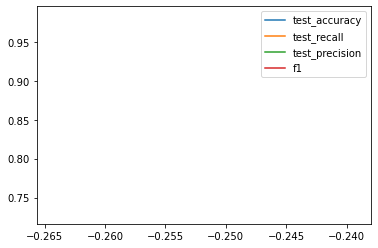

In [39]:
f1 = plt.figure()
ax1 = f1.add_subplot(111)
for k in range(0,len(hp_metrics)):
    ax1.plot(np.log10(hp_x),hp_y[:,k],label=hp_metrics[k])
    
f1 = 2*hp_y[:,1]*hp_y[:,2]/(hp_y[:,1]+hp_y[:,2])
ax1.plot(np.log10(hp_x),f1,label="f1")
    
ax1.legend()
plt.show()

In [40]:
f1

array([0.76379035])

In [ ]:


clf_init = HistGradientBoostingClassifier(random_state=42)
clf = fit_model1(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
score = clf.score(X_train,y_train)

cv_results = cross_validate(clf,X_train,y_train,cv=5,
        scoring=["roc_auc","accuracy","recall","precision"])

print("train score= %f"%score)
print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
print("cv rec= %f"%np.mean(cv_results['test_recall']))
print("cv prec= %f"%np.mean(cv_results['test_precision']))

#print(sigmoid(clf.decision_function(X_train)))
#p_train=clf.predict(X_train)

print("y train:")
print("n pos %f"%np.sum(y_train))
print("frac pos %f"%(np.sum(y_train)/n))

print("y train pred:")
y_train_pred=clf.predict(X_train)
print("n pos %f"%np.sum(y_train_pred))
print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

p_train=clf.predict_proba(X_train)
print("prob sum 0 %f"%np.sum(p_train[:,0]))
print("prob sum 1 %f"%np.sum(p_train[:,1]))

#print(p_train)

print("y test:")
p_test=clf.predict_proba(X_test)
print("prob sum 0 %f"%np.sum(p_test[:,0]))
print("prob sum 1 %f"%np.sum(p_test[:,1]))

if holdout:
    print("holdout metrics:")
    holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
    print("holdout roc auc= %f"%holdout_auc)
    holdout_aucs[i] = holdout_auc

    y_hold_pred = clf.predict(X_hold)
    holdout_acc = accuracy_score(y_hold,y_hold_pred)
    print("holdout acc= %f"%holdout_acc)
    holdout_rec = recall_score(y_hold,y_hold_pred)
    print("holdout rec= %f"%holdout_rec)
    holdout_prec = precision_score(y_hold,y_hold_pred)
    print("holdout prec= %f"%holdout_prec)

In [ ]:
active = df_train[df_train['Active']==1]
asv = active['Sequence'].values
asv_str = ''.join(list(asv))
asv_1plex = asv_str

chars = ''.join(set(asv_str))
feats1 = chars

occ = {}

#1-plex
for i in range(len(chars)):
    count = asv_str.count(chars[i])
    occ[chars[i]] = count
    print("%s: %d"%(chars[i],count))
    



In [ ]:
asv_2plex_list = []
for i in range(len(asv)):
    for j in range(0,3):
        asv_2plex_list.append(asv[i][j:j+2])

feats2 = list(set(asv_2plex_list))
print(len(feats2))

occ = {}
#2-plex
for i in range(len(feats2)):
    count = asv_2plex_list.count(feats2[i])
    occ[feats2[i]] = count
    print("%s: %d"%(feats2[i],count))

In [ ]:
asv_3plex_list = []
for i in range(len(asv)):
    for j in range(0,2):
        asv_3plex_list.append(asv[i][j:j+3])

feats3 = list(set(asv_3plex_list))
print(len(feats3))

occ = {}
#3-plex
for i in range(len(feats3)):
    count = asv_3plex_list.count(feats3[i])
    occ[feats3[i]] = count
    print("%s: %d"%(feats3[i],count))

In [ ]:
len(asv)

In [ ]:
asv_2plex_list

In [ ]:
feats2 = list(set(asv_2plex_list))

In [ ]:
len(feats2)

In [ ]:
feats2

In [ ]:
active = df_train[df_train['Active']!=2]
asv = active['Sequence'].values
asv_str = ''.join(list(asv))
chars = ''.join(set(asv_str))
occ = {}
for i in range(len(chars)):
    count = asv_str.count(chars[i])
    occ[chars[i]] = count
    print("%s: %d"%(chars[i],count))

In [ ]:
useqs

In [ ]:
def standardize(X_train,X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return(X_train,X_test)
    

def impute(X_train,X_test):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(X_train)
    
    X_train = imp_mean.transform(X_train)
    X_test = imp_mean.transform(X_test)

    #print(X_train_imp)
    return(X_train,X_test)

def forest_fi(X_train,y_train,X_test):

    forest = ExtraTreesClassifier(n_estimators=20,
                                  random_state=0)

    forest.fit(X_train,y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    X_train = X_train[:,indices[:50]]
    X_test = X_test[:,indices[:50]]
    return(X_train,X_test)


def nystroem(X_train,X_test):
    gamma=1.0
    n_components=100
    print("nystroem gamma=%f"%(gamma))
    print("nystroem q=%d"%(n_components))
    feature_map_nystroem = Nystroem(gamma=gamma,
                                    random_state=42,
                                    n_components=n_components)
    feature_map_nystroem.fit(X_train)
    Q_train = feature_map_nystroem.transform(X_train)
    sqrt_k_inv_train = np.linalg.inv(feature_map_nystroem.normalization_)
    B_train = np.dot(Q_train,sqrt_k_inv_train)
    K_train = np.dot(B_train,np.transpose(B_train))

    Q_test = feature_map_nystroem.transform(X_test)
    sqrt_k_inv_test = np.linalg.inv(feature_map_nystroem.normalization_)
    B_test = np.dot(Q_test,sqrt_k_inv_test)
    K_test = np.dot(B_test,np.transpose(B_train))
    return(K_train,K_test)


In [ ]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

def fit_model1_1(X_train,y_train):
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, 
                                     max_depth=3, random_state=42).fit(X_train,y_train)
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
    #                                 max_depth=5, random_state=42).fit(X_train_imp,y_train)

    return(clf)

def fit_model1_2(X_train,y_train):
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=10,
                  class_weight="balanced",
                  decision_function_shape='ovo').fit(X_train,y_train)
    return(clf)

def fit_model1(X_train,y_train,clf_init,sw_dict={}):
    n = np.shape(y_train)[0]
    w0 = n/(n-np.sum(y_train))
    w1 = n/np.sum(y_train)
    
    sample_weight = np.zeros(len(y_train))
    if not(sw_dict):
        print("using default sample weights")
        sample_weight[y_train == 0] = w0
        sample_weight[y_train == 1] = w1
    else:
        print("using custom sample weights")
        sample_weight[y_train == 0] = sw_dict[0]
        sample_weight[y_train == 1] = sw_dict[1]
    
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = clf_init
    #clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, 
    #                                 max_depth=3, random_state=42)
    clf.fit(X_train,y_train,sample_weight=sample_weight)
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
    #                                 max_depth=5, random_state=42).fit(X_train_imp,y_train)

    return(clf)

def fit_model2_1(X_train,y_train,hps):
    C = hps["C"]
    #class_weight={1:16.5}
    class_weight={1:hps["w1"]}
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=hps["C"],
                  kernel="rbf",
                  gamma=hps["gamma"],
                  class_weight=class_weight,
                  decision_function_shape='ovo',
                  verbose=True).fit(X_train,y_train)
    print("C: %f"%hps["C"])
    print("gamma: %f"%hps["gamma"])
    print("Computed class weight: %s"%(str(clf.class_weight_)))
    return(clf)

def fit_model2_2(K_train,y_train):
    C = 1.0
    class_weight={1:17.5}
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=C,
                  kernel="precomputed",
                  class_weight="balanced",
                  decision_function_shape='ovo',
                  verbose=True).fit(K_train,y_train)
    print("C: %f"%C)
    print("Computed class weight: %s"%(str(clf.class_weight_)))
    return(clf)

def fit_model2(X_train,y_train,clf_init,sw_dict={}):
    n = np.shape(y_train)[0]
    w0 = n/(n-np.sum(y_train))
    w1 = n/np.sum(y_train)
    
    sample_weight = np.zeros(len(y_train))
    if not(sw_dict):
        print("using default sample weights")
        sample_weight[y_train == 0] = w0
        sample_weight[y_train == 1] = w1
    else:
        print("using custom sample weights")
        sample_weight[y_train == 0] = sw_dict[0]
        sample_weight[y_train == 1] = sw_dict[1]
    
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = clf_init
    clf.fit(X_train,y_train,sample_weight=sample_weight)
    return(clf)

def fit_model3(X_train,y_train):
    #print(np.shape(y_train))
    #print(np.sum(y_train))
    reg = HistGradientBoostingRegressor(random_state=42).fit(X_train,y_train)
    #reg = GradientBoostingRegressor(random_state=42).fit(X_train,y_train)
    return(reg)

In [ ]:
test_pids = pd.unique(df_test_feats['pid'])

df_test_labels = pd.DataFrame(columns=df_labels_cols)
df_test_labels['pid'] = test_pids

In [ ]:
X_train1_raw = feats_2_X1(df_train_feats,active_feats)
X_test1_raw = feats_2_X1(df_test_feats,active_feats)


In [ ]:
print(np.shape(X_train1_raw))
print(np.shape(X_test1_raw))
X_train_imp,X_test = impute(X_train1_raw,X_test1_raw)
print(np.shape(X_train_imp))
print(np.shape(X_test))

holdout_aucs = np.zeros(len(subtask1_labels))

for i in range(0,len(subtask1_labels)):
#for i in range(0,1):
    print("i=%d"%i)
    y_train=df_train_labels[subtask1_labels[i]].values
    n = float(np.shape(y_train)[0])

    if holdout:
        #make hold out
        X_train,X_hold,y_train,y_hold = train_test_split(
            X_train_imp,y_train,test_size=0.2,random_state=42)

        print(np.shape(X_train))
        print(np.shape(X_hold))
        print(np.sum(y_train))
        print(np.sum(y_hold))
        print("\n")
    else:
        X_train = X_train_imp

    #sample weight
    use_custom_sw = True
    if use_custom_sw:
        #sample weight
        n = float(np.shape(y_train)[0])
        w1_boost = 0.17

        w0 = n/(n-np.sum(y_train))
        w1 = (n/np.sum(y_train))*w1_boost
        geo_mean = np.sqrt(w0*w1)
        w0 /= geo_mean
        w1 /= geo_mean
    else:
        w0=1.0
        w1=1.0
    
    clf_init = HistGradientBoostingClassifier(random_state=42)
    clf = fit_model1(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
    score = clf.score(X_train,y_train)
    
    cv_results = cross_validate(clf,X_train,y_train,cv=5,
            scoring=["roc_auc","accuracy","recall","precision"])
    
    print("train score= %f"%score)
    print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
    print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
    print("cv rec= %f"%np.mean(cv_results['test_recall']))
    print("cv prec= %f"%np.mean(cv_results['test_precision']))
    
    #print(sigmoid(clf.decision_function(X_train)))
    #p_train=clf.predict(X_train)
    
    print("y train:")
    print("n pos %f"%np.sum(y_train))
    print("frac pos %f"%(np.sum(y_train)/n))
    
    print("y train pred:")
    y_train_pred=clf.predict(X_train)
    print("n pos %f"%np.sum(y_train_pred))
    print("frac pos %f"%(np.sum(y_train_pred)/n) ) 
    
    p_train=clf.predict_proba(X_train)
    print("prob sum 0 %f"%np.sum(p_train[:,0]))
    print("prob sum 1 %f"%np.sum(p_train[:,1]))
    
    #print(p_train)
    
    print("y test:")
    p_test=clf.predict_proba(X_test)
    print("prob sum 0 %f"%np.sum(p_test[:,0]))
    print("prob sum 1 %f"%np.sum(p_test[:,1]))
    
    if holdout:
        print("holdout metrics:")
        holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
        print("holdout roc auc= %f"%holdout_auc)
        holdout_aucs[i] = holdout_auc

        y_hold_pred = clf.predict(X_hold)
        holdout_acc = accuracy_score(y_hold,y_hold_pred)
        print("holdout acc= %f"%holdout_acc)
        holdout_rec = recall_score(y_hold,y_hold_pred)
        print("holdout rec= %f"%holdout_rec)
        holdout_prec = precision_score(y_hold,y_hold_pred)
        print("holdout prec= %f"%holdout_prec)
    
    print("\n\n")
    
    #y_test[:,1+i] = p_test[:,1]
    
    df_test_labels[subtask1_labels[i]] = p_test[:,1]
    
print("Hold out aucs and mean")
print(holdout_aucs)
print(np.mean(holdout_aucs))

In [ ]:
X_train2_raw = feats_2_X2(df_train_feats,active_feats)
X_test2_raw = feats_2_X2(df_test_feats,active_feats)




In [ ]:
print(np.shape(X_train2_raw))
print(np.shape(X_test2_raw))

X_train_imp,X_test = impute(X_train2_raw,X_test2_raw)
print(np.shape(X_train))
print(np.shape(X_test))

#X_train,X_test = standardize(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))


#X_train,X_test = nystroem(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))

hp_x = np.array([0.05])
hp_metrics = ['hold_roc_auc',
           'hold_accuracy',
           'hold_recall',
           'hold_precision'
          ]
hp_y = np.zeros((hp_x.shape[0],len(hp_metrics)))

for j in range(0,hp_x.shape[0]):
    for i in range(0,len(subtask2_labels)):
    #for i in range(0,1):
        print("i=%d"%i)
        y_train=df_train_labels[subtask2_labels[i]].values
        n = float(np.shape(y_train)[0])

        if holdout:
            #make hold out
            X_train,X_hold,y_train,y_hold = train_test_split(
                X_train_imp,y_train,test_size=0.2,random_state=42)

            print(np.shape(X_train))
            print(np.shape(X_hold))
            print(np.sum(y_train))
            print(np.sum(y_hold))
            print("\n")
        else:
            X_train = X_train_imp

        #sample weight
        use_custom_sw = True
        if use_custom_sw:
            #sample weight
            n = float(np.shape(y_train)[0])
            w1_boost = 0.17

            w0 = n/(n-np.sum(y_train))
            w1 = (n/np.sum(y_train))*w1_boost
            geo_mean = np.sqrt(w0*w1)
            w0 /= geo_mean
            w1 /= geo_mean
        else:
            w0=1.0
            w1=1.0
            
        print("class weights: %f,%f"%(w0,w1))

        clf_init = HistGradientBoostingClassifier(
            learning_rate=hp_x[j],random_state=42)
        clf = fit_model2(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
        score = clf.score(X_train,y_train)

        cv_results = cross_validate(clf,X_train,y_train,cv=5,
                scoring=["roc_auc","accuracy","recall","precision"])

        print("train score= %f"%score)
        print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
        print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
        print("cv rec= %f"%np.mean(cv_results['test_recall']))
        print("cv prec= %f"%np.mean(cv_results['test_precision']))

        #print(sigmoid(clf.decision_function(X_train)))
        #p_train=clf.predict(X_train)

        print("y train:")
        print("n pos %f"%np.sum(y_train))
        print("frac pos %f"%(np.sum(y_train)/n))

        print("y train pred:")
        y_train_pred=clf.predict(X_train)
        print("n pos %f"%np.sum(y_train_pred))
        print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

        p_train=clf.predict_proba(X_train)
        print("prob sum 0 %f"%np.sum(p_train[:,0]))
        print("prob sum 1 %f"%np.sum(p_train[:,1]))

        #print(p_train)

        print("y test:")
        p_test=clf.predict_proba(X_test)
        print("prob sum 0 %f"%np.sum(p_test[:,0]))
        print("prob sum 1 %f"%np.sum(p_test[:,1]))

        if holdout:

            print("holdout metrics:")
            holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
            print("holdout roc auc= %f"%holdout_auc)
            hp_y[j][0] = holdout_auc

            y_hold_pred = clf.predict(X_hold)
            holdout_acc = accuracy_score(y_hold,y_hold_pred)
            print("holdout acc= %f"%holdout_acc)
            hp_y[j][1] = holdout_acc

            holdout_rec = recall_score(y_hold,y_hold_pred)
            print("holdout rec= %f"%holdout_rec)
            hp_y[j][2] = holdout_rec

            holdout_prec = precision_score(y_hold,y_hold_pred)
            print("holdout prec= %f"%holdout_prec)
            hp_y[j][3] = holdout_prec


        print("\n\n")

        #y_test[:,1+i] = p_test[:,1]

        df_test_labels[subtask2_labels[i]] = p_test[:,1]

In [ ]:
f1 = plt.figure()
ax1 = f1.add_subplot(111)
for k in range(0,len(hp_metrics)):
    ax1.plot(np.log10(hp_x),hp_y[:,k],label=hp_metrics[k])
ax1.legend()
plt.show()

In [ ]:
df_test_labels

In [ ]:
X_train3_raw = feats_2_X3(df_train_feats,subtask3_feats)
X_test3_raw = feats_2_X3(df_test_feats,subtask3_feats)


In [ ]:
print(np.shape(X_train3_raw))
print(np.shape(X_test3_raw))

X_train_imp,X_test = impute(X_train3_raw,X_test3_raw)
print(np.shape(X_train_imp))
print(np.shape(X_test))

#X_train,X_test = standardize(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))



holdout_r2s = np.zeros(len(subtask3_labels))

for i in range(0,len(subtask3_labels)):
#for i in range(0,1):
    print("i=%d"%i)
    y_train=df_train_labels[subtask3_labels[i]].values
    
    if holdout:
        #make hold out
        X_train,X_hold,y_train,y_hold = train_test_split(
            X_train_imp,y_train,test_size=0.2,random_state=42)

        print(np.shape(X_train))
        print(np.shape(X_hold))
        print(np.sum(y_train))
        print(np.sum(y_hold))
        print("\n")
    else:
        X_train = X_train_imp

    reg = fit_model3(X_train,y_train)
    
    score = reg.score(X_train,y_train)
    cv_results = cross_validate(reg,X_train,y_train,cv=5,
            scoring=["r2"])
    
    print("train score= %f"%score)
    print("cv r2= %f"%np.mean(cv_results['test_r2']))
    
    y_train_pred=reg.predict(X_train)
    print(np.mean(y_train_pred))
    print(np.std(y_train_pred))
    
    y_test=reg.predict(X_test)
    print(np.mean(y_test))
    print(np.std(y_test))
    
    if holdout:
        print("holdout metrics:")
        holdout_r2 = r2_score(y_hold,reg.predict(X_hold))
        print("holdout roc auc= %f"%holdout_r2)
        holdout_r2s[i] = holdout_r2
        #hp_y[j][0] = holdout_auc
    
    df_test_labels[subtask3_labels[i]] = y_test

In [ ]:
df_test_labels

In [ ]:
df_test_labels.to_csv('prediction_1904_8.zip', index=False, float_format='%.3f', compression='zip')